In [1]:
#!pip install py3dep

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
from dask.distributed import Client
#import py3dep
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import math
import shapely
import matplotlib.pyplot as plt
import os
import xarray as xr
from datetime import datetime
#import ulmo
from datetime import datetime
import sys
import contextily as ctx
import rioxarray as rxr
#from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib
import matplotlib.transforms as mtransforms
import logging
import ipyleaflet
import planetary_computer
import requests
from IPython.display import Image
sys.path.append('../../../sar_snowmelt_timing')
import s1_rtc_bs_utils
import dask_gateway

In [4]:
cluster = dask_gateway.GatewayCluster(shutdown_on_close=False) # 
client = cluster.get_client()
cluster.adapt(minimum=2, maximum=40)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.3a3a33ee15ee41fd83c50da6e1641fd8/status


In [6]:
# create bounding box for Mill Creek
#gj = 'shapefiles/millcreek.geojson'
#bbox_gdf = gpd.read_file(gj)

In [ ]:
# call function to retrieve sentinel acquisitions
# change resolution to 40 for quicker runs
#ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2022-10-01',end_time='2023-06-15',polarization='vv',resolution=40)

In [ ]:
# compute snowmelt timing functions and drop NA dates 
#ts_ds = ts_ds.compute()
#ts_ds = ts_ds.dropna('time',how='all')

In [7]:
# mask out problem pixels 

classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf, comment out lines you want to REMOVE
    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]    

In [8]:
gj = 'shapefiles/millcreek.geojson'
bbox_gdf = gpd.read_file(gj)

ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2022-10-01',end_time='2023-06-15', polarization='vv',resolution=20)
#should polarization be vv?
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds)
ts_ds = ts_ds.where(worldcover.isin(classes))

/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
2023-06-16 17:03:17,899 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [7]:
for year in [2015,2016,2017,2018,2019,2020,2021,20202]:
    melt_year = slice(f'{year}-02-01',f'{year}-09-30')
    ts_ds_oneyear = ts_ds.sel(time=melt_year) 
    runoffs_median = s1_rtc_bs_utils.get_runoff_onset(ts_ds_oneyear,num_acquisitions_during_melt_season=6)
    runoffs_median.dt.dayofyear.rio.to_raster(f'../output/cascades/{nm}/runoff_onset_{nm}_{year}_median_vvvh_10m.tif')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [10]:
ts_ds.copy()

<xarray.DataArray 'stackstac-fd5a66ec6fbc438b401e8eb33d740789' (time: 44,
                                                                y: 1551, x: 1822)>
dask.array<where, shape=(44, 1551, 1822), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates: (12/40)
  * time                                   (time) datetime64[ns] 2022-10-01T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2022...
    band                                   <U2 'vv'
  * x                                      (x) float64 1.458e+06 ... 1.495e+06
  * y                                      (y) float64 5.107e+06 ... 5.076e+06
    sar:resolution_range                   int64 20
    ...                                     ...
    sar:polarizations                      object {'VV', 'VH'}
    description                            <U173 'Terrain-corrected gamma nau...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32610
    spatial_ref                            int64 0
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(1458260, 5075900, 1494720, 51...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 1458260.00|\n| 0.00,-20.00, 5106940.00|\n| 0....
    resolution:  20

In [11]:
snow_classes = [ # https://zenodo.org/record/2626737#.ZDMMf3bMIQ8
    0, #Little-to-no snow
    1, #Indeterminate due to clouds
    2, #Ephemeral snow
    3, #Seasonal snow
]

snow_mask = s1_rtc_bs_utils.get_snowmask(ts_ds)
ts_ds = ts_ds.where(snow_mask.isin(snow_classes))

RasterioIOError: ../input/SnowClass/westernUS_MODIS_snow_classes_byte.tif: No such file or directory

In [ ]:
#f,ax=plt.subplots(2,2,figsize=(15,10))
#s1_rtc_bs_utils.get_py3dep_dem(ts_ds).plot(ax=ax[0,0])
#s1_rtc_bs_utils.get_py3dep_aspect(ts_ds).plot(ax=ax[0,1])
#s1_rtc_bs_utils.get_py3dep_slope(ts_ds).plot(ax=ax[1,0])
#s1_rtc_bs_utils.get_dah(ts_ds).plot(ax=ax[1,1])
#plt.savefig("context.png", dpi=150)

In [12]:
runoff = s1_rtc_bs_utils.get_runoff_onset(ts_ds,return_seperate_orbits=False).dt.dayofyear

TypeError: get_runoff_onset() got an unexpected keyword argument 'return_seperate_orbits'

2023-06-15 18:58:03,512 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [8]:
runoff

<xarray.DataArray 'dayofyear' (y: 1686, x: 1747)>
array([[ 87,  87,   3, ...,  39, 111, 267],
       [ 75,  63, 111, ...,   3,  63, 183],
       [  3,  39,  87, ..., 195,   3,  63],
       ...,
       [  3,  39,  27, ..., 255, 135, 135],
       [  3,  15, 356, ..., 147, 159, 308],
       [344,  39,  51, ..., 147, 159, 308]])
Coordinates: (12/39)
    time                                   (y, x) datetime64[ns] 2022-03-28T1...
    id                                     (y, x) <U66 'S1A_IW_GRDH_1SDV_2022...
    band                                   <U2 'vv'
  * x                                      (x) float64 1.463e+06 ... 1.497e+06
  * y                                      (y) float64 5.107e+06 ... 5.073e+06
    sar:resolution_range                   int64 20
    ...                                     ...
    sar:instrument_mode                    <U2 'IW'
    s1:instrument_configuration_ID         (y, x) <U1 '7' '2' '7' ... '7' '7'
    title                                  <U41 'VV: vertical transmit, verti...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32610

In [ ]:
#runoff.rio.to_raster("runoff.tiff")

In [9]:
polygon = 'inputs/watershed/watershed_bound.shp'
boundary = gpd.read_file(polygon)

In [10]:
lines = 'inputs/watershed/contour_lines1.shp'
contours = gpd.read_file(lines)

In [11]:
boundary = boundary.to_crs(32610)

In [12]:
contours = contours.to_crs(32610)

<Axes: >

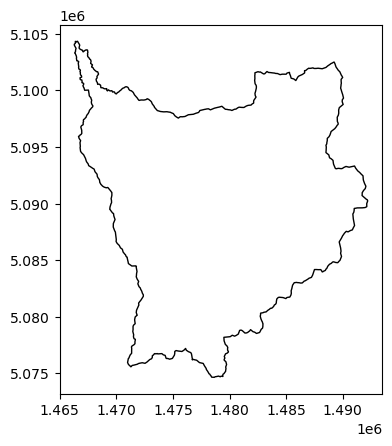

In [13]:
boundary.plot(color='none')

<Axes: >

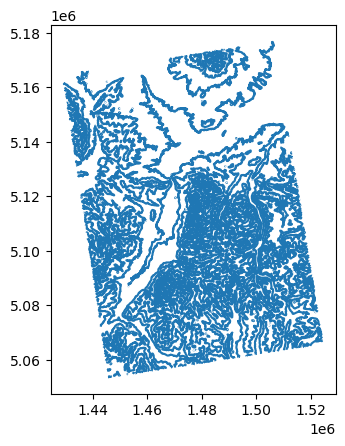

In [14]:
contours.plot()

<Axes: >

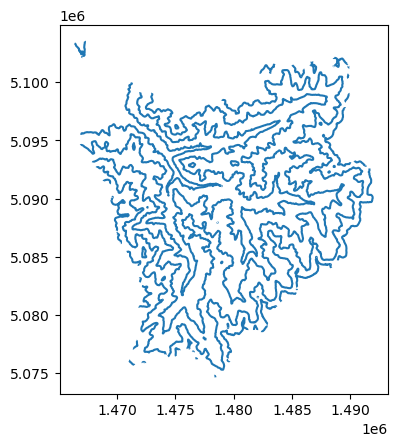

In [15]:
contours_clip = gpd.clip(contours,boundary)
contours_clip.plot()

Text(0.5, 1.0, 'Date of Runoff Onset, Mill Creek Watershed')

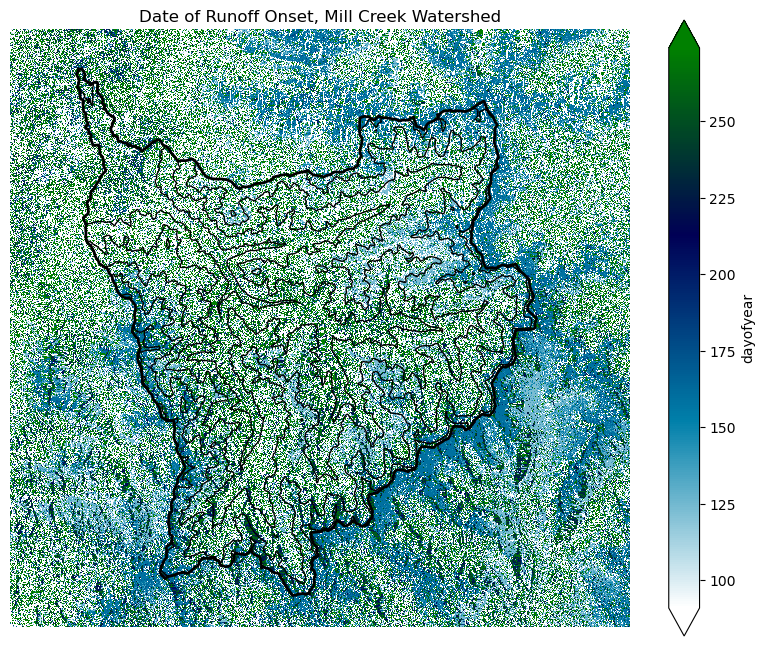

In [16]:
f,ax=plt.subplots(figsize=(10,8))
#runoff.plot(ax=ax,vmin=123,vmax=274,cmap='ocean_r')
runoff.plot(ax=ax,vmin=91,vmax=274,cmap='ocean_r')
boundary.plot(ax=ax,color='none',linestyle='-',linewidth=2)
contours_clip.plot(ax=ax,color='black',linestyle='-',linewidth=1)
plt.axis('off')
plt.title('Date of Runoff Onset, Mill Creek Watershed', pad=5)
#plt.savefig("outputs/runoff2.png", dpi=150)

In [ ]:
names = ['Mill Creek']
geojsons = ['inputs/geo/millcreek.geojson']

In [ ]:
for nm, gj in zip(names,geojsons):
    bbox_gdf = gpd.read_file(gj)
    #ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2015-01-01',end_time='2022-01-01',polarization='vv', resolution=40)
    ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2021-10-01',end_time='2022-09-30',polarization='vv', resolution=40)
    #ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2021-01-01',end_time='2022-01-01',polarization='vv', resolution=40)
    #ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2020-10-01',end_time='2021-09-30',polarization='vv', resolution=40)
    ts_ds = ts_ds.compute()
    ts_ds = ts_ds.dropna('time',how='all')
    
    #f,ax=plt.subplots(figsize=(30,7))
    
    #s1_rtc_bs_utils.plot_sentinel1_acquisitons(ts_ds,ax=ax)
    #f.suptitle(f'{nm}')
    #plt.tight_layout()
    #plt.savefig("acquisitions", dpi=150)

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,7))
s1_rtc_bs_utils.get_runoff_onset(ts_ds).dt.dayofyear.plot(ax=ax[0],cmap='twilight')
s1_rtc_bs_utils.get_ripening_onset(ts_ds).dt.dayofyear.plot(ax=ax[1],cmap='twilight')

In [ ]:
#summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(ts_ds)
summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(ts_ds,start_time='2022-07-30',end_time='2022-09-09')

In [ ]:
f,ax=plt.subplots()
summer_ndvi_ds.plot(ax=ax)
#plt.savefig("ndvi.png", dpi=150)

In [ ]:
s1_rtc_bs_utils.plot_backscatter_ts_and_ndvi(ts_ds,summer_ndvi_ds)
#plt.savefig("veg.png", dpi=150)

In [ ]:
resample_freq_s1='2W'
millcreek_sar_2w_ds = ts_ds.where(summer_ndvi_ds.values<0.2).resample(time='2W').mean(dim='time')
millcreek_sar_2w_ds.rio.write_crs(ts_ds.crs)
dem = s1_rtc_bs_utils.get_py3dep_dem(ts_ds)

In [ ]:
#f,ax=plt.subplots(4,2,figsize=(24,18),gridspec_kw={'width_ratios': [1, 8]})
f,ax=plt.subplots(2,2,figsize=(24,18),gridspec_kw={'width_ratios': [1, 8]})
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(ts_ds,dem,bin_size=100,ax=ax[0,1],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(ts_ds,dem,bin_size=100,ax=ax[1,1],normalize_bins=True)
s1_rtc_bs_utils.plot_hyposometry(ts_ds,dem,bin_size=100,ax=ax[0,0])
s1_rtc_bs_utils.plot_hyposometry(ts_ds,dem,bin_size=100,ax=ax[1,0])
#s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(millcreek_sar_2w_ds,dem,bin_size=100,ax=ax[2,1],normalize_bins=False)
#s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(millcreek_sar_2w_ds,dem,bin_size=100,ax=ax[3,1],normalize_bins=True)
#s1_rtc_bs_utils.plot_hyposometry(millcreek_sar_2w_ds,dem.where(summer_ndvi_ds.values<0.2),bin_size=100,ax=ax[2,0])
#s1_rtc_bs_utils.plot_hyposometry(millcreek_sar_2w_ds,dem.where(summer_ndvi_ds.values<0.2),bin_size=100,ax=ax[3,0])
ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
#ax[2,0].invert_xaxis()
#ax[3,0].invert_xaxis()
#plt.tight_layout()
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle("Sentinel-1 SAR Backscatter binned by Elevation")
#plt.savefig("elevation", dpi=150)